# Soft Actor Critic Agent(115 Points)

> Name: Yalda Shabanzadeh

> SID: 98101822



In this notebook, we are going to implement **Soft Actor Critic (SAC)**
on the **CartPole** environment in online and offline settings. In this framework, the actor aims to maximize the expected reward while also maximizing **entropy**. That is, to succeed at the task while acting as randomly as possible. This method seeks a high entropy in the policy to explicitly encourage exploration. For the offline setting, you are going to make SAC conservative using CQL method.

* SAC is an off-policy algorithm.
* The version of SAC implemented here can only be used for environments with discrete action spaces.
* An alternate version of SAC, which slightly changes the policy update  rule, can be implemented to handle continuous action spaces.
* Complete the **TODO** parts in the code accordingly.
* Remember to answer the conceptual questions.




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import math


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Network Structure (8 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [3]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO (4 points):
        # Define your network layers.
        ##########################################################
        self.fc1 = nn.Linear(input_dimension, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dimension)
        self.output_activation = output_activation
        ##########################################################

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO (4 points):
        # Use relu and the output activation functions to calculate the output
        ##########################################################
        x = F.relu(self.fc1(inpt))
        x = F.relu(self.fc2(x))
        output = self.output_activation(self.fc3(x))
        return output
        ##########################################################

## Replay Buffer

A SAC agent needs a replay buffer, from which previously visited states can be sampled. You can use the implemented code below. You are going to use the replay buffer of a pretrained online agent to train the offline model.

In [4]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## Questions (18 points)

❓ We know that standard RL maximizes the expected sum of rewards. What is the objective function of SAC algorithm? Compare it to the standard RL loss.
> Soft Actor-Critic (SAC) is an algorithm that optimizes a stochastic policy in an off-policy way, forming a bridge between stochastic policy optimization and DDPG-style approaches. The objective function of SAC is to maximize the expected sum of rewards plus an entropy term. The entropy term encourages exploration by discouraging the policy from becoming too certain about its actions.

> $J(\theta)=\Sigma_{t=0}^{T}\mathbb{E}_{(s_t,a_t)\sim{\rho_\pi}}[r(s_t,a_t) + \alpha H(\pi(.|s_t))]$


❓ Write down the actor cost function.
> We train the Policy network $\pi$ by minimizing the following error:

 $J_{\pi}(\phi)=\mathbb{E}_{s_t\sim{D}}[D_{KL}(\pi_{\phi}(.|s_t)||\frac{\exp(Q_\theta(s_t,.))}{Z_{\theta}(s_t)})]$

> This objective function is basically trying to make the distribution of our Policy function look more like the distribution of the exponentiation of our Q Function normalized by another function Z.

❓ Write down the critic cost function.
> We train the Q network by minimizing the following error:

$J_{Q}(\theta)=\mathbb{E}_{(s_t,a_t)\sim{D}}[\frac{1}{2}(Q_{\theta}(s_t,a_t)-\hat{Q}(s_t,a_t))^2]$
where \\
$\hat{Q}(s_t,a_t)=r(s_t,a_t)+\gamma\mathbb{E}_{s_{t+1}\sim p}[V_{\bar{\psi}}(s_{t+1})]$

> Minimizing this objective function amounts to the following: For all (state, action) pairs in the experience replay buffer, we want to minimize the squared difference between the prediction of our Q function and the immediate (one time-step) reward plus the discounted expected Value of the next state. Note that the Value comes from a Value function parameterized by $\bar{\psi}$. This is an additional Value function called the target value function.

> Also we train the Value network by minimizing the following error:

$J_{V}(\psi)=\mathbb{E}_{s_t\sim{D}}[\frac{1}{2}(V_{\psi}(s_t)-\mathbb{E}_{a_t\sim\pi_\phi}[Q_\theta(s_t,a_t)-\log \pi_\phi (a_t|s_t)])^2]$


❓ Elaborate on the reason why most implementations of SAC use two critics (one local and one target).

> SAC makes use of three networks: a state value function V parameterized by $\psi$, a soft Q-function Q parameterized by $\theta$, and a policy function $\pi$ parameterized by $\phi$. While there is no need in principle to have separate approximators for the V and Q functions which are related through the policy, the authors say that in practice having separate function approximators help in convergence. So we need to train the three function approximators as told above.

> The local critic is updated at each training step, while the target critic is a slowly updated version of the local critic. By using two critics, it helps to reduce the overestimation bias that can occur in single-critic architectures. The target critic provides a more stable and accurate estimate of the Q-values, leading to improved learning and performance.



❓ What is the difference between training samples in offline and online settings?
> In the offline setting, the agent learns from a fixed dataset of pre-collected experiences. The training samples are already available, and the agent does not interact with the environment during training. The dataset typically consists of state-action pairs and corresponding rewards. On the other hand, in the online setting, the agent interacts with the environment in real-time, collecting experiences and using them to update the policy and value function estimations.



❓ How does adding CQL on top of SAC change the objective function?
> When CQL (Conservative Q-Learning) is added to SAC, it changes the objective function by introducing an additional term that encourages the policy to be conservative and match the behavior of the offline dataset. The CQL loss penalizes the policy for taking actions that deviate significantly from the behavior observed in the offline dataset. It helps to ensure that the learned policy stays within a conservative region and avoids exploring actions that may have a high variance or risk. Therefore, the objective function of SAC with CQL includes the additional CQL loss term, which modifies the policy update to be more conservative.





## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [51]:
class SACAgent:

    ALPHA_INITIAL = 1.
    REPLAY_BUFFER_BATCH_SIZE = 100
    DISCOUNT_RATE = 0.99
    LEARNING_RATE = 10 ** -4
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
    TRADEOFF_FACTOR = 5 # trade-off factor in the CQL

    def __init__(self, environment, replay_buffer=None, use_cql=False, offline=False):

        assert (use_cql and offline) or (not use_cql), 'Please activate the offline flag for CQL.'
        assert (offline and replay_buffer is not None) or (not offline), 'Please pass a replay buffer to the offline method.'

        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.offline = offline
        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.use_cql = use_cql

        ##########################################################
        # TODO (6 points):
        # Define critics usig your implemented feed forward netwrok.
        ##########################################################
        self.critic_local = Network(self.state_dim, self.action_dim)
        self.critic_local2 = Network(self.state_dim, self.action_dim)
        self.critic_optimiser = torch.optim.Adam(
            self.critic_local.parameters(), lr=self.LEARNING_RATE)
        self.critic_optimiser2 = torch.optim.Adam(
            self.critic_local2.parameters(), lr=self.LEARNING_RATE)
        self.critic_target = Network(self.state_dim, self.action_dim)
        self.critic_target2 = Network(self.state_dim, self.action_dim)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO (2 points):
        # Define the actor using your implemented feed forward netwrok.
        # Define the actor optimizer using torch.Adam.
        ##########################################################
        self.actor_local = Network(
            self.state_dim,
            self.action_dim,
            torch.nn.Softmax(dim=1)
        )
        self.actor_optimiser = torch.optim.Adam(
            self.actor_local.parameters(), lr=self.LEARNING_RATE)
        ##########################################################

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha.exp()
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def cql_loss(self, q_values, soft_q_values):
        logsumexp_q_values = torch.logsumexp(q_values, dim=1)
        return logsumexp_q_values.mean() - soft_q_values.mean()

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO (12 points):
        # You are going to calculate critic losses in this method.
        # Also you should implement the CQL loss if the corresponding
        # flag is set.
        ##########################################################
        critic_loss, critic2_loss = 0, 0
        with torch.no_grad():
            action_probs, log_action_probs = self.get_action_info(next_states_tensor)
            q1_target_next = self.critic_target(next_states_tensor)
            q2_target_next = self.critic_target2(next_states_tensor)
            soft_state_values = (action_probs * (
                    torch.min(q1_target_next, q2_target_next) + -self.alpha * log_action_probs
            )).sum(dim=1)

            next_q_values = rewards_tensor + ~done_tensor * self.DISCOUNT_RATE * soft_state_values

        q1_local = self.critic_local(states_tensor)
        q2_local = self.critic_local2(states_tensor)
        batch_range = torch.arange(states_tensor.size(0))
        soft_q_values = q1_local[batch_range, actions_tensor]
        soft_q_values2 = q2_local[batch_range, actions_tensor]
        critic_mse = torch.nn.MSELoss(reduction="none")(soft_q_values, next_q_values)
        critic2_mse = torch.nn.MSELoss(reduction="none")(soft_q_values2, next_q_values)
        weight_update = torch.min(critic_mse, critic2_mse).detach().squeeze().cpu().numpy()
        self.replay_buffer.update_weights(weight_update)
        critic_loss = critic_mse.mean()
        critic2_loss = critic2_mse.mean()

        if self.use_cql and self.offline:
            cql_loss = self.cql_loss(q1_local, soft_q_values)
            cql_loss2 = self.cql_loss(q2_local, soft_q_values2)
            critic_loss += self.TRADEOFF_FACTOR * cql_loss
            critic2_loss += self.TRADEOFF_FACTOR * cql_loss2

        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor):
        ##########################################################
        # TODO (8 points):
        # Now implement the actor loss.
        ##########################################################
        actor_loss, log_action_probabilities = 0, 0
        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)
        q_values = self.critic_local(states_tensor)
        q_values2 = self.critic_local2(states_tensor)
        min_q_values = torch.min(q_values, q_values2)
        inside_term = self.alpha * log_action_probabilities - min_q_values
        actor_loss = (action_probabilities * inside_term).sum(dim=1).mean()
        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO (6 points):
        # Set all the gradients stored in the optimizers to zero.
        # Add the new transition to the replay buffer for online case.
        ##########################################################
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()

        if not self.offline:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE,
                                                            batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
            # TODO (16 points):
            # Here, you should compute the gradients based on this loss, i.e. the gradients
            # of the loss with respect to the Q-network parameters.
            # Given a minibatch of 100 transitions from replay buffer,
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it.
            # You also need to update \alpha.
            ##########################################################
            critic_loss, critic2_loss = self.critic_loss(
                states_tensor, actions_tensor, rewards_tensor,
                next_states_tensor, done_tensor
            )
            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()
            ##########################################################

            self.soft_update_target_networks()
            return np.array(minibatch_separated[2]) # rewards

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC training loop (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

In [7]:
def plot_learning_curves(total_results):
    mean_returns = np.mean(total_results, axis=0)
    run_std_devs = np.std(total_results, axis=0)
    std_devs = np.mean(run_std_devs)

    plt.plot(mean_returns)
    plt.fill_between(range(len(mean_returns)), mean_returns - std_devs, mean_returns + std_devs, alpha=0.3)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Return")
    plt.title("Learning Curves")
    plt.show()


def plot_episode_mean(episode_rewards, episode):
    plt.plot(episode_rewards)
    plt.xlabel(f"Episodes * {TRAINING_EVALUATION_RATIO}")
    plt.ylabel("Mean Reward")
    plt.title(f"Episode = {episode}")
    plt.show()

In [49]:
from IPython.display import clear_output


def run_training(replay_buffer, num_runs):
    total_results = []

    for run in range(num_runs):
        agent = SACAgent(env)
        run_results = []

        for episode in range(EPISODES_PER_RUN):
            print('\r', f'Run: {run + 1}/{num_runs} | Episode: {episode + 1}/{EPISODES_PER_RUN}', end=' ')
            state = env.reset()
            evaluation_episode = episode % TRAINING_EVALUATION_RATIO == 0
            episode_reward = 0

            for step in range(STEPS_PER_EPISODE):
                action = agent.get_next_action(state, evaluation_episode)
                next_state, reward, done, _ = env.step(action)
                transition = (state, action, reward, next_state, done)
                replay_buffer.add_transition(transition)

                if not evaluation_episode:
                    agent.train_on_transition(state, action, next_state, reward, done)
                else:
                    episode_reward += reward
                state = next_state

                if done:
                    break

            if evaluation_episode:
                clear_output()
                run_results.append(episode_reward)
                plot_episode_mean(run_results, episode)

        total_results.append(run_results)

    return total_results

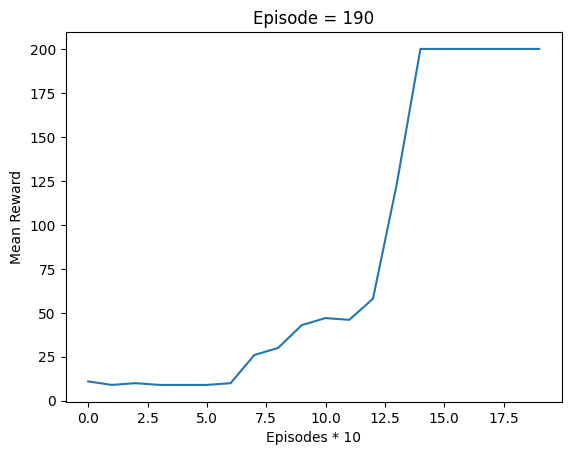

 Run: 4/4 | Episode: 200/200 

In [52]:
TRAINING_EVALUATION_RATIO = 10
EPISODES_PER_RUN = 200
STEPS_PER_EPISODE = 200

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.
##########################################################


replay_buffer = ReplayBuffer(env)
total_results = run_training(replay_buffer, num_runs=4)

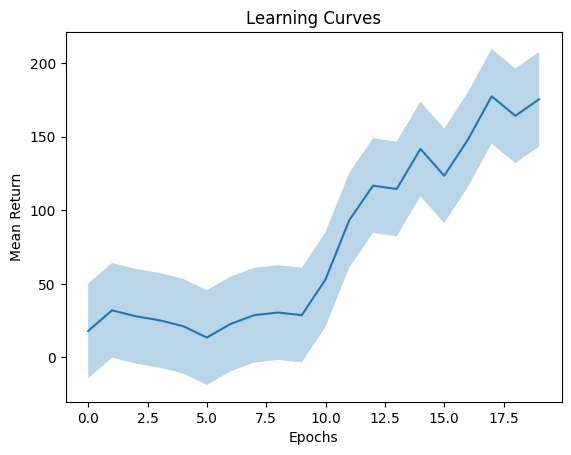

In [10]:
plot_learning_curves(total_results)

In [42]:
import pickle

pickle.dump(replay_buffer, open("sac_replay_buffer.pkl", "wb"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Offline SAC training loop (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

In [79]:
import tqdm


def run_offline_training(replay_buffer, num_runs, use_cql=False):
    total_results = []

    batch_size = 100
    for run in range(num_runs):
        agent = SACAgent(environment=env, replay_buffer=replay_buffer, use_cql=use_cql, offline=True)
        run_results = []

        for epoch in tqdm.tqdm(range(NUM_EPOCHS)):
            batch_deterministic_start = 0
            while batch_deterministic_start < replay_buffer.get_size():
                agent.train_networks(batch_deterministic_start=batch_deterministic_start)
                batch_deterministic_start += batch_size

            epoch_result = []
            for episode in range(EPISODES_PER_RUN):
                state = env.reset()
                evaluation_episode = episode % TRAINING_EVALUATION_RATIO == 0
                episode_reward = 0

                for step in range(STEPS_PER_EPISODE):
                    action = agent.get_next_action(state, evaluation_episode)
                    next_state, reward, done, _ = env.step(action)

                    episode_reward += reward
                    state = next_state

                    if done:
                        break

                if evaluation_episode:
                    epoch_result.append(episode_reward)

            run_results.append(np.mean(epoch_result))
        total_results.append(run_results)
    return total_results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 200

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################

total_results_offline = run_offline_training(replay_buffer, num_runs=RUNS, use_cql=False)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 200/200 [43:42<00:00, 13.11s/it]


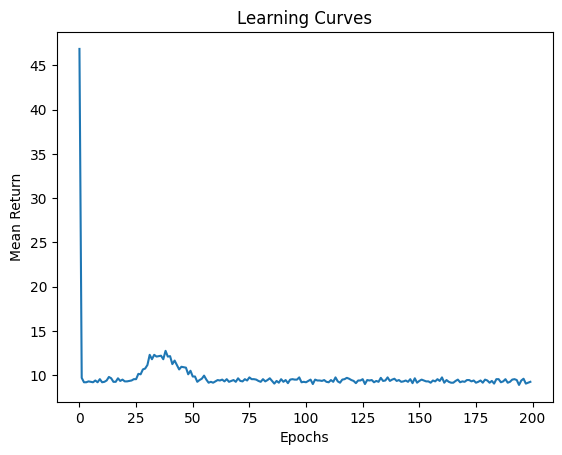

In [81]:
plot_learning_curves(total_results_offline)

## Conservative SAC training loop (5 points)

Similar to the previous part, you are going to train another offline agent. In this part, you are going to use the conservative version of SAC.

In [82]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 200

env = gym.make("CartPole-v1")

##########################################################
# TODO (5 points):
# Implement the training loop for the conservative SAC.
# 1) You need to initialize an agent with the current
#    `replay_buffer` of the online agent. Set the `offline`
#     and `use_cql` flags.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################


total_results_cql = run_offline_training(replay_buffer, num_runs=RUNS, use_cql=True)

100%|██████████| 200/200 [1:11:55<00:00, 21.58s/it]


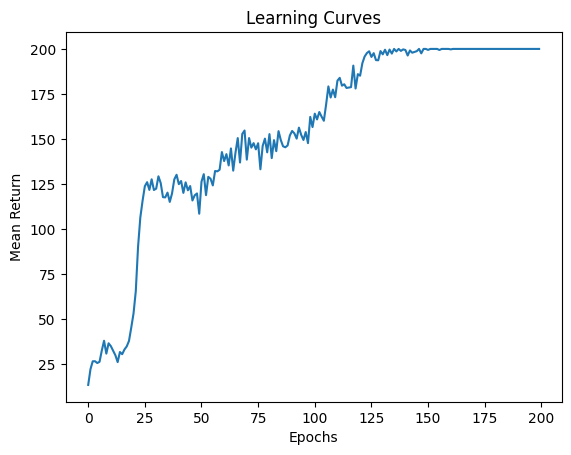

In [83]:
plot_learning_curves(total_results_cql)

## Comparisons (14 points)
Now, analyze your results and justify the trends you see. Then answer the following questions.

> In terms of performance, online SAC can achieve state-of-the-art results on many continuous control tasks, but it can be sensitive to the choice of hyperparameters and the exploration strategy. Offline SAC can also achieve good performance, but it typically requires more data and may not generalize well to new states. C-Offline SAC can achieve similar or better performance than offline SAC while also improving the robustness and generalization of the learned policy.

> In terms of sample efficiency, online SAC can be more sample-efficient than offline SAC since it can use the most recent data to update the policy. However, offline SAC can be more efficient in terms of data collection since it can reuse existing data and doesn't require interaction with the environment. C-Offline SAC can achieve similar or better sample efficiency than offline SAC since it can reuse existing data while also improving the quality of the learned policy.

> Here, we can see that the results of online SAC and it's convergence and stablity is better than the others. Then, CQL has a greate effect on offline SAC and make it reach the results in online SAC.

❓ What is the reason for the difference between online and offline performance of the agent?

> The difference between the online and offline performance of the agent is due to the availability of data. In the online setting, the agent learns directly from interactions with the environment, which allows it to adapt and improve its policy based on the rewards and feedback it receives in real-time. On the other hand, in the offline setting, the agent learns from a fixed dataset of pre-collected experiences. This dataset may not fully represent the dynamics and complexities of the environment, leading to a performance gap between online and offline learning.

❓ Which one is better: offline SAC or conservative SAC?

> The better option between offline SAC and conservative SAC depends on the specific requirements and constraints of the problem at hand. Offline SAC can leverage a large pre-collected dataset and potentially achieve good performance. However, it may also be sensitive to biases and limitations in the dataset, leading to suboptimal results. On the other hand, conservative SAC, such as SAC with CQL, introduces additional constraints to make the policy more conservative and match the behavior observed in the offline dataset. This can help mitigate the issues of dataset biases and improve the safety and stability of the learned policy. Therefore, if preserving safety and robustness is a priority, conservative SAC may be a better choice.

❓ What is the effect of `TRADEOFF_FACTOR` in the offline setting? How does changing its value affect the results?

> The `TRADEOFF_FACTOR` in the offline setting controls the trade-off between exploration and sticking to the behavior observed in the offline dataset. A higher TRADEOFF_FACTOR encourages the agent to be more conservative and stay closer to the observed behavior, while a lower value allows for more exploration and deviation from the dataset. Increasing the TRADEOFF_FACTOR leads to a more conservative policy that is less likely to explore new actions and more likely to follow the behavior observed in the offline dataset. Conversely, decreasing the TRADEOFF_FACTOR allows for more exploration and deviation from the dataset, which can lead to a potentially more adaptive and innovative policy. The choice of the TRADEOFF_FACTOR should be based on the specific requirements and trade-offs of the problem, considering factors such as the quality and representativeness of the offline dataset and the desired level of exploration.
